In [1]:
from keras.datasets import mnist
import tensorflow as tf
(X_train,y_train),(X_test,y_test)=mnist.load_data()


Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [2]:
print("Number of training datasets : %d"% len(X_train))
print("Number of testing datasets : %d"% len(X_test))

Number of training datasets : 60000
Number of testing datasets : 10000


In [3]:
print(X_train.shape)

(60000, 28, 28)


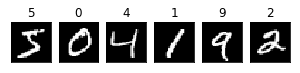

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

# plot first six training images
fig = plt.figure(figsize=(5,5))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(str(y_train[i]))

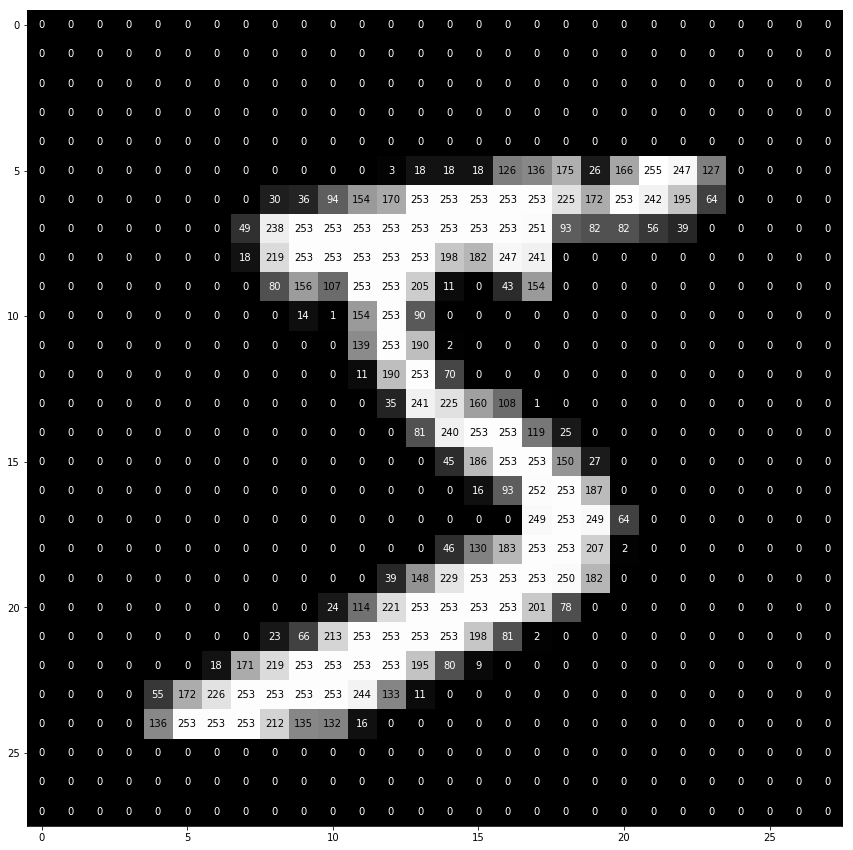

In [5]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (15,15)) 
ax = fig.add_subplot(111)
visualize_input(X_train[0], ax)



In [0]:
X_train=X_train.astype('float32')/255
X_test=X_test.astype('float32')/255

In [7]:
from keras.utils.np_utils import to_categorical as tc
print(y_train[:10]) #integer form
y_train=tc(y_train,10)
y_test=tc(y_test,10)
print(y_train[:10]) #categorical form

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [0]:
def network_layer(inputs,n_nodes,name,activation=None):
  with tf.name_scope(name):
    n_inputs = int(inputs.shape[1])
    std_dev = 2/np.sqrt(n_inputs)
    init = tf.truncated_normal((n_inputs,n_nodes),stddev=std_dev)
    W = tf.Variable(init,name="Weights")
    b = tf.Variable(tf.zeros([n_nodes]),name='Biases')
    output = tf.matmul(inputs,W) + b
    if(activation=='relu'):
      return tf.nn.relu(output)
    elif(activation=='sigmoid'):
      return tf.nn.sigmoid(output)
    else:
      return output

In [0]:
tf.reset_default_graph()
n_hidden1 = 512
n_hidden2 = 512
x_train = np.reshape(X_train,(X_train.shape[0],-1))
x_test = np.reshape(X_test,(X_test.shape[0],-1))
n_classes=10
n_features = x_train.shape[1]
inputs = tf.placeholder(tf.float32,shape=[None,n_features],name='inputs')
outputs = tf.placeholder(tf.int64,shape=[None,n_classes],name='inputs')

In [0]:
with tf.name_scope("DNN"):
  hidden1=network_layer(inputs,n_hidden1,"hidden1",activation='relu')
  hidden2=network_layer(hidden1,n_hidden2,"hidden2",activation='relu')
  logits=network_layer(hidden2,n_classes,"logits")
with tf.name_scope("loss"):
  loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=outputs,logits=logits),name="avg_xentropy")
with tf.name_scope("train"):    
    learning_rate=0.01
    optimizer =  tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op= optimizer.minimize(loss)
with tf.name_scope("accuracy"): 
    correct = tf.equal(tf.argmax(logits, 1), tf.argmax(outputs, 1))
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
with tf.name_scope("init"):
    init=tf.global_variables_initializer()

In [0]:
def iterate_batch(inputs,targets,shuffle=False,batch_size=1):
  assert inputs.shape[0]==targets.shape[0]
  if shuffle:
    ind = np.arange(inputs.shape[0])
    np.random.shuffle(ind)
  for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
    if shuffle:
       excerpt = indices[start_idx:start_idx + batch_size]
    else:
       excerpt = slice(start_idx, start_idx + batch_size)
    yield inputs[excerpt], targets[excerpt]

In [56]:
n_epochs = 25
batch_size=64
with tf.Session() as sess:
    init.run()
    max_acc=0
    acc_going_down=0
    for epoch in range(n_epochs):
        batch_step=0
        avg_loss = 0.
        total_loss= 0.
        total_batch = int(X_train.shape[0]/batch_size)
        
        for X_batch, Y_batch in iterate_batch(x_train,y_train,batch_size=batch_size):
            _,l=sess.run([training_op,loss],feed_dict={inputs:X_batch, outputs:Y_batch})
            batch_step+=1
            total_loss += l
        if((epoch)%10==0):
            avg_loss = total_loss/batch_size
            print("Epoch:", '%02d' % (epoch+1), "| Average Training Loss= {:.2f}".format(avg_loss), "| Training Accuracy:  {:.2f}".format(accuracy.eval({inputs: x_train, outputs: y_train})), "| Test/Validation Accuracy:  {:.2f}".format(accuracy.eval({inputs: x_test, outputs: y_test})))
    print("Model fit complete.")
    print("Final Training Accuracy: {:.2f}".format(accuracy.eval({inputs: x_train, outputs: y_train})))
    print("Final Validation Accuracy: {:.2f}".format(accuracy.eval({inputs: x_test, outputs: y_test})))

Epoch: 01 | Average Training Loss= 4.46 | Training Accuracy:  0.94 | Test/Validation Accuracy:  0.93
Epoch: 11 | Average Training Loss= 1.40 | Training Accuracy:  0.98 | Test/Validation Accuracy:  0.97
Epoch: 21 | Average Training Loss= 0.91 | Training Accuracy:  0.98 | Test/Validation Accuracy:  0.97
Model fit complete.
Final Training Accuracy: 0.99
Final Validation Accuracy: 0.97


Test accuracy: 97.6100%
